# Image Stitching

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [15, 15]

In [8]:
# Read image and convert them to gray!!
def read_image(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img, img_rgb

In [9]:
left_gray, left_origin, left_rgb = read_image('ImageStitching/Image1.jpeg')
right_gray, right_origin, right_rgb = read_image('ImageStitching/Image2.jpeg')

In [10]:
def SIFT(img):
    siftDetector= cv2.xfeatures2d.SIFT_create() # limit 1000 points
    # siftDetector= cv2.SIFT_create()  # depends on OpenCV version

    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(gray, kp, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

In [11]:
# Better result when using gray
kp_left, des_left = SIFT(left_gray)
kp_right, des_right = SIFT(right_gray)

[ WARN:0@68.646] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


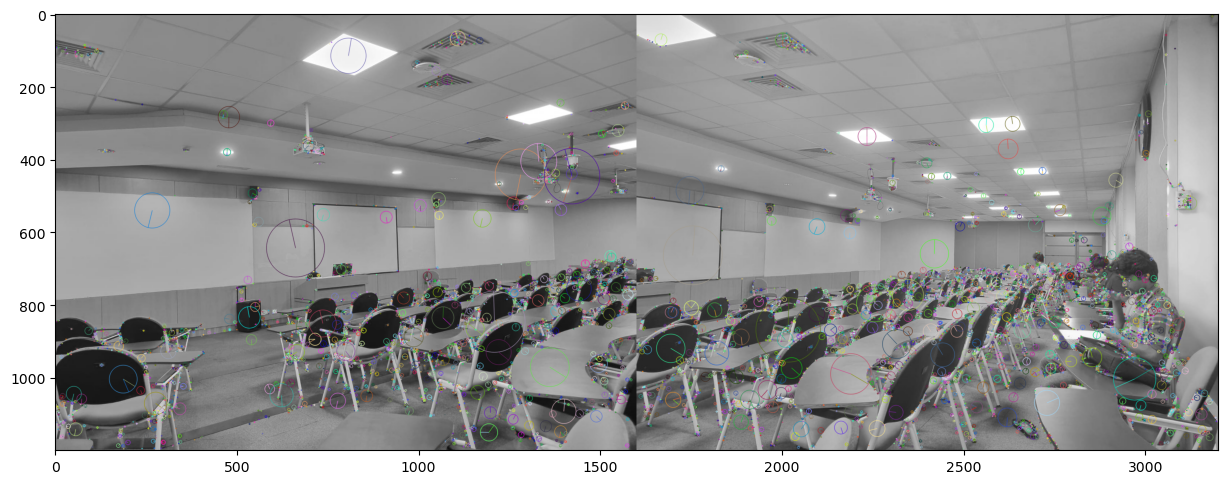

In [12]:
kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
plt.imshow(total_kp)

In [13]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

In [14]:
matches = matcher(kp_left, des_left, left_rgb, kp_right, des_right, right_rgb, 0.5)

In [15]:
def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type
    
    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
     
    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()

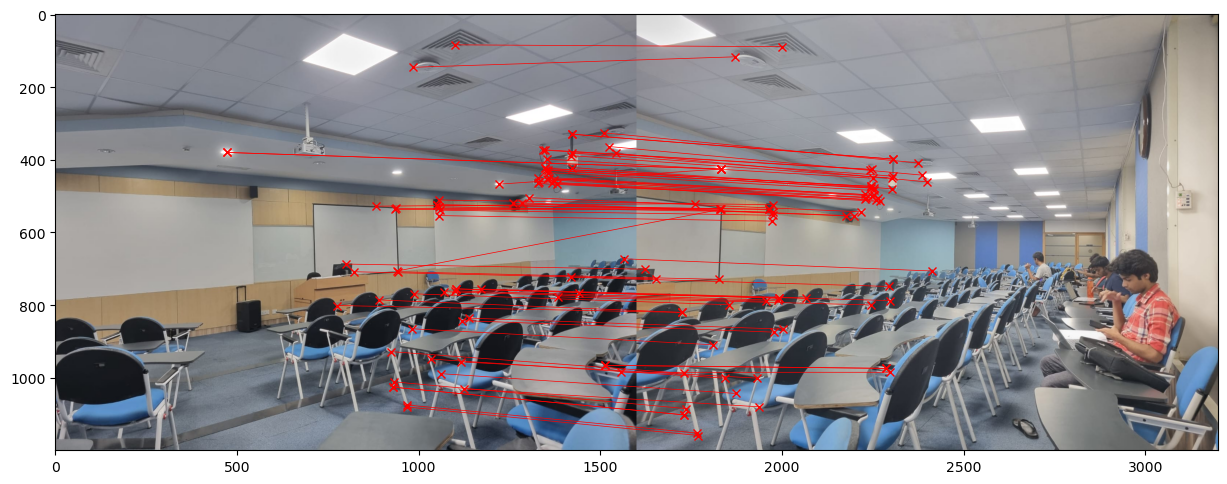

In [16]:
total_img = np.concatenate((left_rgb, right_rgb), axis=1)
plot_matches(matches, total_img) # Good mathces

In [17]:
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

In [18]:
def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

In [19]:
def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

In [20]:
def ransac(matches, threshold, iters):
    num_best_inliers = 0
    
    for i in range(iters):
        points = random_point(matches)
        H = homography(points)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

In [21]:
inliers, H = ransac(matches, 0.5, 2000)

inliers/matches: 19/73


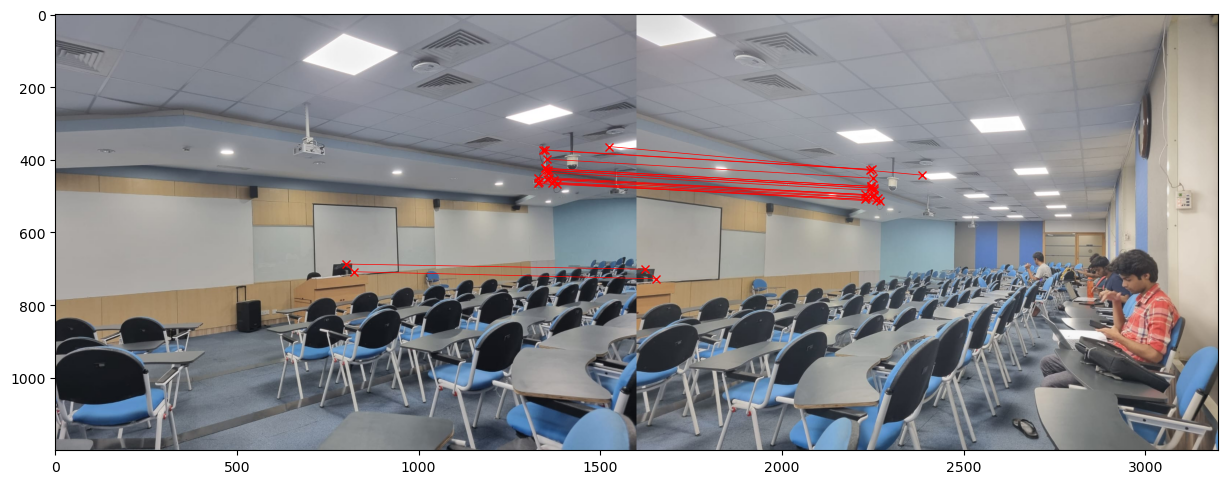

In [22]:
plot_matches(inliers, total_img) # show inliers matches

In [23]:
def stitch_img(left, right, H):
    print("stiching image ...")
    
    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None, 
                            0.0, 1.0, cv2.NORM_MINMAX)   
    # Convert to double and normalize.
    right = cv2.normalize(right.astype('float'), None, 
                            0.0, 1.0, cv2.NORM_MINMAX)   
    
    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T 
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)

    height_r, width_r, channel_r = right.shape
    
    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)
    

    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)
     
    black = np.zeros(3)  # Black pixel.
    
    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]
            
            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass
                  
    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image

stiching image ...


  0%|          | 0/1854 [00:00<?, ?it/s]

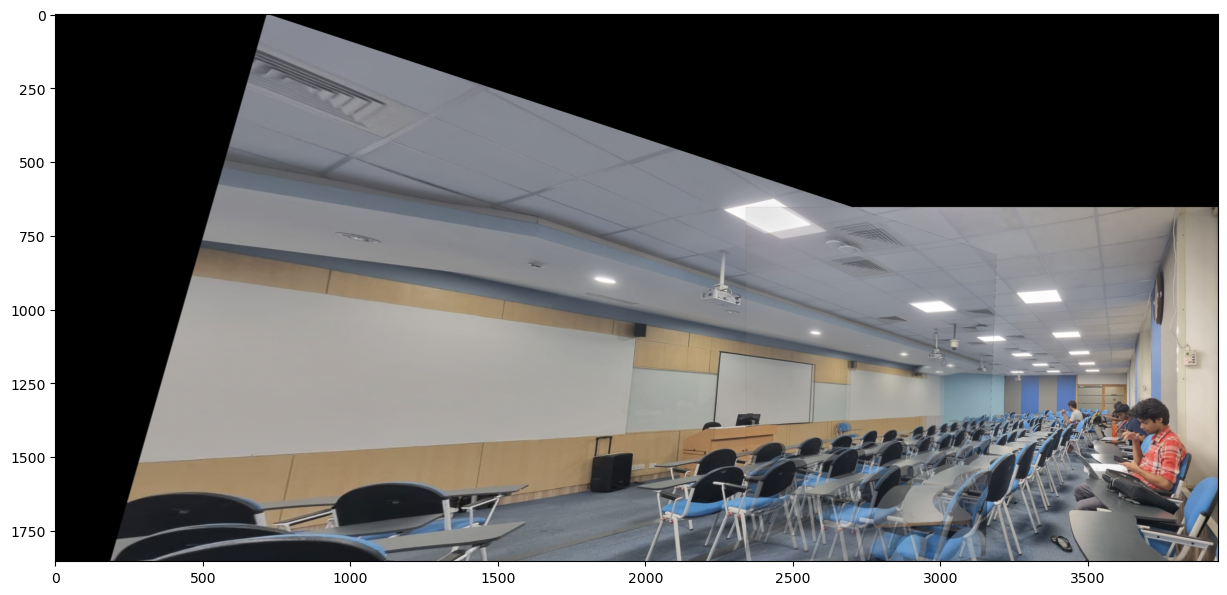

In [24]:
plt.imshow(stitch_img(left_rgb, right_rgb, H))